# 데이터 불러오기 / 라벨링

In [ ]:
import numpy as np
import pandas as pd
import os

paths = []
dataset_gubuns = []
label_gubuns = []

for dirname, _, filenames in os.walk('/kaggle/input/emotion/data/'):
    for filename in filenames:
        if '.png' in filename:
            file_path = dirname+'/'+filename
            paths.append(file_path)
            if '/train/' in file_path:
                dataset_gubuns.append('train')
            elif '/test/' in file_path:
                dataset_gubuns.append('test')

            if 'angry' in file_path:
                label_gubuns.append('angry')
            elif 'disgusted' in file_path:
                label_gubuns.append('disgusted')
            elif 'fearful' in file_path:
                label_gubuns.append('fearful')
            elif 'happy' in file_path:
                label_gubuns.append('happy')
            elif 'neutral' in file_path:
                label_gubuns.append('neutral')
            elif 'sad' in file_path:
                label_gubuns.append('sad')
            elif 'surprised' in file_path:
                label_gubuns.append('surprised')

In [59]:
data_df = pd.DataFrame({'path': paths, 'dataset': dataset_gubuns, 'label': label_gubuns})

In [60]:
data_df.head()

,path,dataset,label
0,/kaggle/input/emotion/data/test/fearful/im292.png,test,fearful
1,/kaggle/input/emotion/data/test/fearful/im1022...,test,fearful
2,/kaggle/input/emotion/data/test/fearful/im633.png,test,fearful
3,/kaggle/input/emotion/data/test/fearful/im934.png,test,fearful
4,/kaggle/input/emotion/data/test/fearful/im927.png,test,fearful


# 이미지 크기 확인

(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


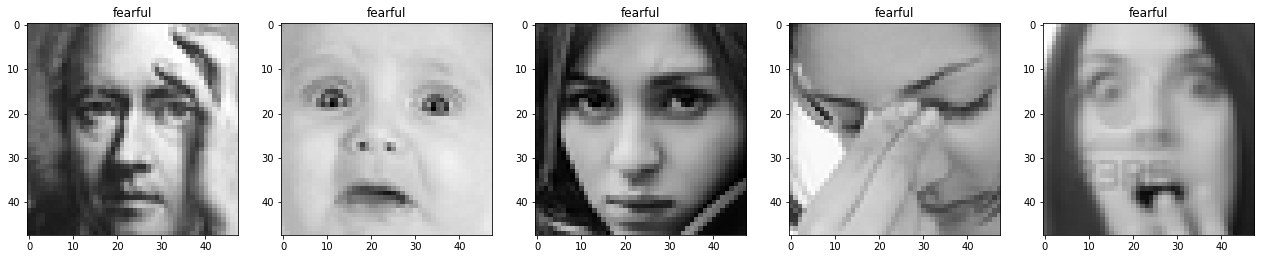

In [61]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')

def show_images(images, labels, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])
        print(images[i].shape)
images = []
for i in data_df['path'].head():
    images.append(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
labels = []
for i in data_df['label'].head():
    labels.append(i)
show_images(images, labels, ncols = 5)

# Sequence 기반 Dataset을 생성하고 호출하기

In [62]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

BATCH_SIZE = 64
IMAGE_SIZE = 40

class Dataset(Sequence):

    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        
        if self.shuffle:
            #self.on_epoch_end()
            pass
        
    def __len__(self):
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    def __getitem__(self, index):
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
            
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            if self.pre_func is not None:
                image = self.pre_func(image)
              
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    def on_epoch_end(self):
        if(self.shuffle):
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass            

## train과 validation 데이터셋으로 나누고 원-핫 인코딩 적용

In [63]:
from sklearn.model_selection import train_test_split

train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

train_images = train_df['path'].values
train_labels = pd.get_dummies(train_df['label']).values
test_images = test_df['path'].values
test_labels = pd.get_dummies(test_df['label']).values

tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.15)

In [64]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.2),
    A.CLAHE(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.ShiftScaleRotate(p=0.3)
])

tr_ds = Dataset(tr_images, tr_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=True)
val_ds = Dataset(val_images, val_labels,  batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

# EfficientNet 모델 생성

In [65]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = EfficientNetB0(input_tensor = input_tensor, include_top=False, weights='imagenet')

bm_output = base_model.output
x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(1000, activation = 'relu', name='fc1')(x)
x = Dense(500, activation = 'relu', name='fc2')(x)
output  = Dense(7, activation = 'softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 40, 40, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 40, 40, 3)    7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 41, 41, 3)    0           normalization_5[0][0]            
____________________________________________________________________________________________

In [67]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1)

history = model.fit(tr_ds, epochs=50,
                    validation_data=val_ds,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/50
382/382 [==============================] - 58s 134ms/step - loss: 1.6622 - accuracy: 0.3474 - val_loss: 1.4780 - val_accuracy: 0.4460
Epoch 2/50
382/382 [==============================] - 49s 129ms/step - loss: 1.3775 - accuracy: 0.4813 - val_loss: 1.3354 - val_accuracy: 0.5062
Epoch 3/50
382/382 [==============================] - 49s 129ms/step - loss: 1.2986 - accuracy: 0.5130 - val_loss: 1.2746 - val_accuracy: 0.5289
Epoch 4/50
382/382 [==============================] - 49s 128ms/step - loss: 1.2056 - accuracy: 0.5449 - val_loss: 1.2603 - val_accuracy: 0.5407
Epoch 5/50
382/382 [==============================] - 49s 128ms/step - loss: 1.1732 - accuracy: 0.5574 - val_loss: 1.2120 - val_accuracy: 0.5449
Epoch 6/50
382/382 [==============================] - 49s 128ms/step - loss: 1.1386 - accuracy: 0.5752 - val_loss: 1.2171 - val_accuracy: 0.5449
Epoch 7/50
382/382 [==============================] - 49s 128ms/step - loss: 1.1094 - accuracy: 0.5916 - val_loss: 1.1874 - val_ac

# 테스트 및 결과 확인

In [68]:
test_ds = Dataset(test_images, test_labels,  batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)
model.evaluate(test_ds)

113/113 [==============================] - 21s 186ms/step - loss: 1.1765 - accuracy: 0.6184


[1.176457405090332, 0.6184173822402954]

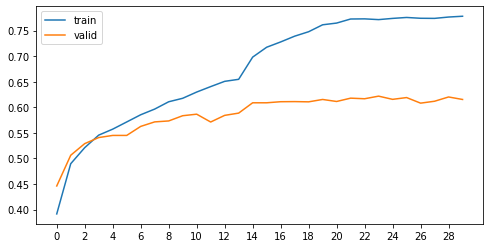

In [69]:
def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)
